In [106]:
!pip install chess

import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F
import numpy as np
import math
import random
from collections import namedtuple, deque
import chess
import chess.svg

import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import time

In [2]:
# Setting device
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

# Model

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Shortcut connection for dimension matching
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Add residual connection
        out = self.relu(out)
        return out

In [4]:
block = ResidualBlock(3, 16, 3)
test = torch.rand((1, 3, 64, 64))
block(test).shape

torch.Size([1, 16, 64, 64])

In [5]:
class DQN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.features = nn.Sequential(
            ResidualBlock(in_channels, 32, 3),
            ResidualBlock(32, 32, 3),
            ResidualBlock(32, 64, 3),
            ResidualBlock(64, 64, 3),
            ResidualBlock(64, 128, 3),
            ResidualBlock(128, 128, 3),
            ResidualBlock(128, 73, 3),
            nn.Conv2d(73, 73, kernel_size=3,    # output head
                      stride=1, padding=1)
        )

    def forward(self, x):
        x = self.features(x)
        return x

In [6]:
test_model = DQN(19)
test = torch.rand((10, 19, 8, 8))
test_out = test_model(test)
test_out.shape

torch.Size([10, 73, 8, 8])

# Replay Memory

In [7]:
Transition = namedtuple('Transition',
                        ('turn', 'state', 'action', 'next_fen', 'next_state', 'terminal', 'reward'))


class ReplayMemory(object):
    def __init__(self, capacity, batch_size):
        self.capacity = capacity
        self.memory = deque([], maxlen=self.capacity)
        self.batch_size = batch_size

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def extend(self, list_of_transitions):
        self.memory.extend(list_of_transitions)

    def sample(self, batch_size=None):
        if batch_size is None:
          return random.sample(self.memory, self.batch_size)
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
rm = ReplayMemory(10000, 8)
data = [Transition(*list(range(7)))] * 10
rm.extend(data)
transitions = rm.sample(5)
batch = Transition(*zip(*transitions))

In [10]:
batch.turn

(0, 0, 0, 0, 0)

# Class of Helper Functions That Connect Model to Chess Board

In [218]:
class ChessHelper():
  def __init__(self, step_history=5):
    # Calculates shape of tensor for current board state
    board_size = 8
    planes_for_pieces = 2*6 + 1
    planes_for_rules = 1 + 4 + 1
    amount_of_input_planes =  planes_for_rules + planes_for_pieces
    self.input_shape = (amount_of_input_planes, board_size, board_size)
    # Tracks how many previous moves the model should account for
    self.step_history = step_history
    history_planes = step_history*planes_for_pieces
    self.history_input = (history_planes,board_size,board_size)
    self.white_history = torch.zeros(self.history_input)
    self.black_history = torch.zeros(self.history_input)

    # Maps channels of model output to moves and promotions
    # Format: (Δcol, Δrow, promotion) where promotion=0 means no promotion according to row and column of output tensor
    self.channel_map = self.fill_channel_map()

  def fill_channel_map(self):
    """
    Maps each of the 73 channels of model output to a specific move and promotion.
    """
    channel_map = []
    # Directions: (Δcol, Δrow)
    queen_directions = [
      (-1, 1),  # Up-Left
      (0, 1),   # Up
      (1, 1),   # Up-Right
      (1, 0),   # Right
      (1, -1),  # Down-Right
      (0, -1),  # Down
      (-1, -1),  # Down-Left
      (-1, 0)  # Left
    ]

    # Generate queen moves
    for dc, dr in queen_directions:
      for distance in range(1, 8):  # 1 to 7 squares
        channel_map.append([dc * distance, dr * distance, 0])

    # Knight move offsets
    knight_moves = [
      (-1, 2),   # Up-Left
      (1, 2),   # Up-Right
      (2, 1),   # Right-Up
      (2, -1),  # Right-Down
      (1, -2),  # Down-Right
      (-1, -2), # Down-Left
      (-2, -1), # Left-Down
      (-2, 1)  # Left-Up
    ]

    # Generate knight moves
    for dc, dr in knight_moves:
      channel_map.append([dc, dr, 0])

    # Underpromotion moves
    underpromotion_moves = [
      (-1, 1),  # Capture left
      (0, 1),   # Forward
      (1, 1)   # Capture right
    ]

    # Promotion piece types
    promotion_pieces = [chess.KNIGHT, chess.BISHOP, chess.ROOK]

    # Generate underpromotion moves
    for promo in promotion_pieces:
      for dc, dr in underpromotion_moves:
        channel_map.append([dc, dr, promo])

    return torch.tensor(channel_map, dtype=torch.int16)

  # TODO: credit wherever we got this code from
  def board_state_to_input(self, fen: str):
    """
    Convert board to a state that is interpretable by the model. Flip's the board on black's turn.
    """

    board = chess.Board(fen)

    # 1. is it white's turn? (1x8x8)
    is_white_turn = torch.ones((8, 8)) if board.turn else torch.zeros((8, 8))

    # 2. castling rights (4x8x8)
    castling = torch.stack([
        torch.ones((8, 8)) if board.has_queenside_castling_rights(
            chess.WHITE) else torch.zeros((8, 8)),
        torch.ones((8, 8)) if board.has_kingside_castling_rights(
            chess.WHITE) else torch.zeros((8, 8)),
        torch.ones((8, 8)) if board.has_queenside_castling_rights(
            chess.BLACK) else torch.zeros((8, 8)),
        torch.ones((8, 8)) if board.has_kingside_castling_rights(
            chess.BLACK) else torch.zeros((8, 8)),
    ])

    # 3. repitition counter
    counter = torch.ones(
        (8, 8)) if board.can_claim_fifty_moves() else torch.zeros((8, 8))

    # create new torch array
    arrays = []
    # tracking the order of the tensor
    order = []
    if board.turn:
      order = chess.COLORS
    else:
      order = [False,True]

    for color in order:
        # 4. player 1's pieces (6x8x8)
        # 5. player 2's pieces (6x8x8)
        for piece_type in chess.PIECE_TYPES:
            # 6 arrays of 8x8 booleans
            array = torch.zeros((8, 8))
            for index in list(board.pieces(piece_type, color)):
                # row calculation: 7 - index/8 because we want to count from bottom left, not top left
                if board.turn:
                  array[7 - int(index/8)][index % 8] = True
                else:
                  array[int(index/8)][7 - index % 8] = True
            arrays.append(array)
    arrays = torch.stack(arrays)

    # 6. en passant square (8x8)
    en_passant = torch.zeros((8, 8))
    if board.has_legal_en_passant():
        en_passant[7 - int(board.ep_square/8)][board.ep_square % 8] = True

    r = torch.stack([is_white_turn, *castling,
                counter, *arrays, en_passant]).reshape((1, *self.input_shape))
    # memory management
    del board
    return r.float()

  def masker(self, output_tensor, board_fen):
      board = chess.Board(board_fen)

      #If it is white we make a mask of -infinity, if black we set mask to positive infinity
      if board.turn:
          mask = torch.full_like(output_tensor, float('-inf'))
      else:
          mask = torch.full_like(output_tensor, float('inf'))

      # converting legal moves to the form (delta file, delta rank, promotion, from_square_rank, and from_square_file)
      legal_moves = []
      for move in board.legal_moves:
        from_file = chess.square_file(move.from_square)
        from_rank = chess.square_rank(move.from_square)
        to_file = chess.square_file(move.to_square)
        to_rank = chess.square_rank(move.to_square)

        # Converting rank and file to row and column index in output tensor
        if board.turn:
          from_row = 7 - from_rank
          from_col = from_file
          to_row = 7 - to_rank
          to_col = to_file
        else:
          from_row = from_rank
          from_col = 7 - from_file
          to_row = to_rank
          to_col = 7 - to_file

        dc = to_col - from_col
        dr = from_row - to_row
        promo = move.promotion if move.promotion else 0
        # In channel map, queen promotions are counted as regular queen moves
        if promo == chess.QUEEN:
          promo = 0

        legal_moves.append((dc, dr, promo, from_col, from_row))

      # if no legal moves... all infinity
      if not legal_moves:
        return output_tensor + mask

      # Track legal moves
      move_tensor = torch.tensor(legal_moves, dtype=torch.int16)
      move_deltas = move_tensor[:, :3]

      # Compare against all 73 channels via broadcasting
      delta_diff = move_deltas[:, None, :] == self.channel_map[None, :, :]  # (N, 73, 3)
      matches = delta_diff.all(dim=2)  # (N, 73)
      move_indexs, channel_indexs = matches.nonzero(as_tuple=True)

      # Convert these to long for indexing
      col_indexs = move_tensor[move_indexs, 3].long()
      row_indexs = move_tensor[move_indexs, 4].long()
      channel_indexs = channel_indexs.long()

      # Set mask to 0 for legal moves
      mask[0, channel_indexs, row_indexs, col_indexs] = 0.0

      return output_tensor + mask

  def board_state(self,fen:str):

    board = chess.Board(fen)

    # create new torch array
    arrays = []
    # tracking the order of the tensor
    order = []
    if board.turn:
      order = chess.COLORS
    else:
      order = [False,True]

    for color in order:
        # 4. player 1's pieces (6x8x8)
        # 5. player 2's pieces (6x8x8)
        for piece_type in chess.PIECE_TYPES:
            # 6 arrays of 8x8 booleans
            array = torch.zeros((8, 8))
            for index in list(board.pieces(piece_type, color)):
                # row calculation: 7 - index/8 because we want to count from bottom left, not top left
                if board.turn:
                  array[7 - int(index/8)][index % 8] = True
                else:
                  array[int(index/8)][7 - index % 8] = True
            arrays.append(array)
    arrays = torch.stack(arrays)

    # 6. en passant square (8x8)
    en_passant = torch.zeros((8, 8))
    if board.has_legal_en_passant():
        en_passant[7 - int(board.ep_square/8)][board.ep_square % 8] = True

    r = torch.stack([*arrays, en_passant]).reshape((13, 8, 8))
    # memory management
    del board
    return r.float()


  def add_to_history(self, fen):
    #base case
    if self.step_history == 0:
        self.white_history = torch.empty((0,8,8))
        self.black_history = torch.empty((0,8,8))
        return  # No need to store history if step_history is 0

    board = chess.Board(fen)
    state = self.board_state(fen).squeeze(0)  # (13, 8, 8)

    if board.turn:  # white to move
      prev_history = self.white_history[13:]
      if self.step_history > 1:
        new_history = torch.cat([state,prev_history], dim = 0)[:self.history_input[0] - 13]
      else:
        new_history = torch.empty((0,8,8))
      self.white_history = torch.cat([state, new_history], dim = 0)
    else:  # black to move
      prev_history = self.black_history[13:]
      if self.step_history > 1:
        new_history = torch.cat([state,prev_history], dim = 0)[:self.history_input[0] - 13]
      else:
        new_history = torch.empty((0,8,8))
      self.black_history = torch.cat([state, new_history], dim = 0)

  def concat_step_history(self, fen):
    board = chess.Board(fen)

    new_input = self.board_state_to_input(fen)
    new_input = new_input.float()

    if board.turn:
      history = self.white_history.unsqueeze(0)
    else:
      history = self.black_history.unsqueeze(0)

    if self.step_history == 0:
      return new_input
    else:
      stacked = torch.cat([new_input, history], dim=1)
      self.add_to_history(fen)
      return stacked

  def output_to_optimal_indices(self, output, fen):
    """
    Takes output of model and gets the channel index, row, and column of the
    maximum or minimum value, depending if it is white's or black's turn,
    respectively.

    Output: (channel, row, col)
    """
    board = chess.Board(fen)

    if board.turn == chess.WHITE:
      flat_optimal_indices = output.flatten(start_dim=1).argmax(dim=1)
    else:
      flat_optimal_indices = output.flatten(start_dim=1).argmin(dim=1)
    channel, row, col = torch.unravel_index(flat_optimal_indices, (73, 8, 8))

    # Memory management
    del board

    return (channel.cpu(), row.cpu(), col.cpu())

  def indices_to_move(self, fen, channel_indices, row_indices, col_indices):
    """
    Takes indices to output of model and converts it to format for chess.Move

    Input: Channel, row, and column indices corresponding to desired moves in model output
    Output: (from_square: torch.tensor, to_square: torch.tensor, promotion: List)
    """
    board = chess.Board(fen)

    # Getting move delta and promotion info from channel index
    move_details = self.channel_map[channel_indices]
    dc, dr, promotion = move_details[:,0], move_details[:,1], move_details[:,2]

    # Calculating new location of piece
    to_col = col_indices + dc
    to_row = row_indices - dr

    # Converting from rows and cols to rank and file
    if board.turn == chess.WHITE:
      from_rank = 7 - row_indices
      from_file = col_indices
      to_rank = 7 - to_row
      to_file = to_col
    else:
      # Black's perspective is flipped
      from_rank = row_indices
      from_file = 7 - col_indices
      to_rank = to_row
      to_file = 7 - to_col

    # Changing from rank and file to square index
    from_square = chess.square(from_file, from_rank)
    to_square = chess.square(to_file, to_rank)

    # Error catcher
    if board.piece_at(from_square) is None:
      print('\n', board.fen(), '\n')
      print('channel, row, col', channel_indices, row_indices, col_indices, '\n')
      raise Exception('Error caught in indices_to_move.')

    # Checking for pawn to queen promotion
    if board.piece_at(from_square).piece_type == chess.PAWN and (to_rank == 0 or to_rank == 7):
      promotion = torch.tensor([chess.QUEEN])

    # Promotion=0 means no promotion
    promotion = [p.item() if p != 0 else None for p in promotion]

    # Memory management
    del board

    return (from_square, to_square, promotion)

  def output_to_move(self, output, fen):
    """
    Takes output of model, chooses the best move, and converts it to format for chess.Move.
    Wrapper function for output_to_optimal_indices and indices_to_move.

    Input: 1x73x8x8 tensor where each plane corresponds to a specific move
    Output: (from_square: torch.tensor, to_square: torch.tensor, promotion: List)
    """
    optimal_indices = self.output_to_optimal_indices(output, fen)
    from_square, to_square, promotion = self.indices_to_move(fen, *optimal_indices)
    return (from_square, to_square, promotion)

  def move_to_index(self, turn, move):
    # Getting starting and ending square for move
    from_file = chess.square_file(move.from_square)
    from_rank = chess.square_rank(move.from_square)
    to_file = chess.square_file(move.to_square)
    to_rank = chess.square_rank(move.to_square)

    # Converting rank and file to row and column index in output tensor
    if turn:
      from_row = 7 - from_rank
      from_col = from_file
      to_row = 7 - to_rank
      to_col = to_file
    else:
      from_row = from_rank
      from_col = 7 - from_file
      to_row = to_rank
      to_col = 7 - to_file

    # Getting move deltas and promotion
    dc = to_col - from_col
    dr = from_row - to_row
    promotion = move.promotion if move.promotion in [chess.KNIGHT, chess.BISHOP, chess.ROOK] else 0
    move_details = torch.tensor([dc, dr, promotion])

    # Getting corresponding index of tensor from rank and file
    channel_idx = torch.where((self.channel_map == move_details).all(dim=1))[0]

    # Changing from_row and from_col to tensor to keep consistent index output
    return channel_idx, torch.tensor([from_row]), torch.tensor([from_col])

## Testing History Function

In [360]:
# checking history functions
chess_helper = ChessHelper(step_history=3)
board = chess.Board()
input = chess_helper.concat_step_history(board.fen())
print(input.shape)
# white pawns
print(input[0, 6, :, :])
# zero padding
print(torch.all(input[0, 20:, :, :] == 0))

torch.Size([1, 58, 8, 8])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor(True)


In [12]:
board.push(chess.Move.from_uci("e2e4"))
input2 = chess_helper.concat_step_history(board.fen())

In [13]:
# black pawns
print(input2[0, 6, :, :])
# zero padding
print(torch.all(input2[0, 20:, :, :] == 0))

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor(True)


In [14]:
board.push(chess.Move.from_uci("e7e5"))
input3 = chess_helper.concat_step_history(board.fen())

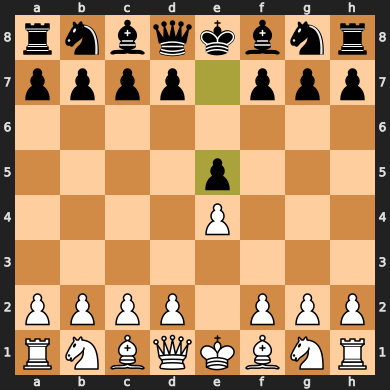

In [15]:
board

In [16]:
# white pawns
print(input3[0, 6, :, :])
print(input3[0, 19, :, :])
# zero padding
print(torch.all(input3[0, 32:, :, :] == 0))

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor(False)


In [17]:
input3[0, 32, :, :]

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
# checking history functions
chess_helper = ChessHelper(step_history=3)
board = chess.Board()
input = chess_helper.concat_step_history(board.fen())
print(input.shape)
# white pawns
print(input[0, 6, :, :])
# zero padding
print(torch.all(input[0, 20:, :, :] == 0))

torch.Size([1, 58, 8, 8])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor(True)


In [19]:
# chess_helper.add_to_history(board.fen())
# board.push(chess.Move.from_uci("e7e5"))

In [ ]:
# ---- Test Run ----
helper = ChessHelper(step_history=1)

fen1 = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
fen2 = "rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1"
fen3 = "rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq e6 0 2"

helper.add_to_history(fen1)
helper.add_to_history(fen2)

# Combine current board + history
combined = helper.concat_step_history(fen3)

print("Combined shape:", combined.shape)

Combined shape: torch.Size([1, 32, 8, 8])


In [ ]:
board = chess.Board()

In [ ]:
chess_helper.concat_step_history(board.fen())

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

## Testing Chess Helper Class

test output shape: torch.Size([1, 73, 8, 8])
--------------------------------------------------------------------
(tensor([8]), tensor([6]), tensor([4]))
(tensor([12]), tensor([28]), [None])
(tensor([8]), tensor([6]), tensor([4]))
--------------------------------------------------------------------
torch.Size([1, 19, 8, 8])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
--------------------------------------------------------------------


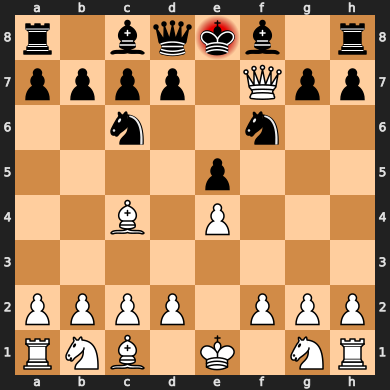

In [219]:
# Testing board output
board = chess.Board()
chess_helper = ChessHelper()
test_model = DQN(19)
test = torch.rand((1, 19, 8, 8))
test_out = test_model(test)
test_out = chess_helper.masker(test_out, board.fen())
print(f"test output shape: {test_out.shape}")
print('--------------------------------------------------------------------')

# Making sure that move_to_index and indices_to_move are inverses
opt_indices = chess_helper.output_to_optimal_indices(test_out, chess.STARTING_FEN)
print(opt_indices)
move_details = chess_helper.indices_to_move(chess.STARTING_FEN, *opt_indices)
print(move_details)
move_details = move_details[:2] + (0,)
returned_indices = chess_helper.move_to_index(board.turn, chess.Move(*move_details))
print(returned_indices)#
assert(opt_indices == returned_indices)
print('--------------------------------------------------------------------')

# Testing board_state_to_input
fen = 'r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 0 4'
board = chess.Board(fen)
input = chess_helper.board_state_to_input(fen)
print(input.shape)
# Showing black pawns (and orients to black player's perspective)
print(input[0, 6, :, :])
print('--------------------------------------------------------------------')
board

## Testing Masked Output

In [224]:
# Generate random boards and make sure legal moves are not masked and illegal moves are masked
board = chess.Board()
chess_helper = ChessHelper()
while board.outcome() is None:
  test_output = torch.randn((1, 73, 8, 8))
  test_output = chess_helper.masker(test_output, board.fen())
  is_finite = torch.isfinite(test_output)
  for move in board.legal_moves:
    # Get corresponding index in output tensor for move
    channel_idx, row_idx, col_idx = chess_helper.move_to_index(board.turn, move)
    # See if the legal move is improperly masked
    assert(is_finite[0, channel_idx, row_idx, col_idx])
  # See if illegal moves are not masked
  assert(torch.sum(is_finite) == len(list(board.legal_moves)))
  rand_legal_move = np.random.choice(list(board.legal_moves))
  board.push(rand_legal_move)

In [150]:
output = torch.randn(1, 73, 8, 8)
fen = chess.STARTING_FEN

masker_test = ChessHelper()
masked = masker_test.masker(output, fen)

# Legal moves
print("Legal move indices:", (masked != float('-inf')).nonzero())

Legal move indices: tensor([[ 0,  7,  6,  0],
        [ 0,  7,  6,  1],
        [ 0,  7,  6,  2],
        [ 0,  7,  6,  3],
        [ 0,  7,  6,  4],
        [ 0,  7,  6,  5],
        [ 0,  7,  6,  6],
        [ 0,  7,  6,  7],
        [ 0,  8,  6,  0],
        [ 0,  8,  6,  1],
        [ 0,  8,  6,  2],
        [ 0,  8,  6,  3],
        [ 0,  8,  6,  4],
        [ 0,  8,  6,  5],
        [ 0,  8,  6,  6],
        [ 0,  8,  6,  7],
        [ 0, 56,  7,  1],
        [ 0, 56,  7,  6],
        [ 0, 57,  7,  1],
        [ 0, 57,  7,  6]])


# Running an Episode

In [226]:
# Credit: https://github.com/suragnair/alpha-zero-general/blob/master/Coach.py
def execute_episode(dqn, epsilon):
  """
  This function executes one episode of self-play, starting with player 1.
  As the game is played, each turn is added as a training example to
  trainExamples. The game is played till the game ends. After the game
  ends, the outcome of the game is used to assign values to each example
  in trainExamples.

  Output:
    white_train_examples: a list of examples of the form (state, action, next state, reward, terminal)
                      terminal is 1 if game ends on the turn, else 0
                      reward is +1 if white wins, -1 if black wins, 0 if draw or not
                      winning
    black_train_examples: same as white_train_examples but for black
  """
  board = chess.Board()
  chess_helper = ChessHelper(step_history=0)
  # Containers to store training examples in format (turn, state, action, next state, terminal, reward)
  white_train_examples = []
  black_train_examples = []

  while True:
    curr_state = board.fen()
    curr_input = chess_helper.board_state_to_input(curr_state).to(device)
    # Calculating best move and moving board
    output = dqn(curr_input)
    output = chess_helper.masker(output, curr_state)

    # Epsilon-Greedy policy
    unif = torch.rand(1)
    # Random policy; choose random move
    if unif < epsilon:
      chosen_move = np.random.choice(list(board.legal_moves))
      move_indices = chess_helper.move_to_index(board.turn, chosen_move)
    # Greedy policy; get indices corresponding to move with optimal Q-value
    else:
      move_indices = chess_helper.output_to_optimal_indices(output, board.fen())
      from_square, to_square, promotion = chess_helper.indices_to_move(board.fen(), *move_indices)
      chosen_move = chess.Move(from_square, to_square, promotion[0])
      # Error catcher
      if chosen_move not in board.legal_moves:
        print('board fen', board.fen())
        raise Exception('\nSomething wrong in greedy policy or masker')

    # Executing chosen move on board
    board.push(chosen_move)
    next_state = board.fen()
    # TODO: change board_state_to_input to concat_history
    next_input = chess_helper.board_state_to_input(next_state)

    # Saving training example in different containers because different rewards will be given
    outcome = board.outcome()
    # Reversing board turn because next move has already been pushed
    turn = 1 - board.turn
    # If game continues then add to train examples
    if (outcome is None):
      train_example = Transition(turn, curr_input, move_indices, next_state, next_input, 0, None)
      if turn:
        white_train_examples.append(train_example)
      else:
        black_train_examples.append(train_example)
    # If game ends then give out rewards
    else:
      train_example = Transition(turn, curr_input, move_indices, next_state, next_input, 1, None)
      if outcome.winner == chess.WHITE:
        white_train_examples.append(train_example)
        white_train_examples = [example[:-1] + (1,) for example in white_train_examples]
        black_train_examples = [example[:-1] + (0,) for example in black_train_examples]
      elif outcome.winner == chess.BLACK:
        black_train_examples.append(train_example)
        white_train_examples = [example[:-1] + (0,) for example in white_train_examples]
        black_train_examples = [example[:-1] + (-1,) for example in black_train_examples]
      # Draw
      else:
        if turn:
          white_train_examples.append(train_example)
        else:
          black_train_examples.append(train_example)
        white_train_examples = [example[:-1] + (0,) for example in white_train_examples]
        black_train_examples = [example[:-1] + (0,) for example in black_train_examples]

      # Memory management
      del board

      return white_train_examples, black_train_examples

In [227]:
def update(dqn, target_dqn, rm, optimizer, criterion=nn.SmoothL1Loss(), gamma=0.99, tau=1e-3):
  """
  Updates policy network using replay memory and soft updates target network.
  Gamma is the discount factor in the TD loss.
  Tau is the update rate of the target network.
  """
  # Sampling from replay memory
  transitions = rm.sample()
  batch = Transition(*zip(*transitions))
  # Collecting batched data
  turns = torch.tensor(batch.turn, dtype=bool).to(device)
  states = torch.cat(batch.state, dim=0).to(device)
  actions = torch.tensor(batch.action).to(device)
  next_fens = batch.next_fen
  next_states = torch.cat(batch.next_state, dim=0).to(device)
  terminals = torch.tensor(batch.terminal).to(device)
  rewards = torch.tensor(batch.reward).to(device)

  # Double Q-learning
  with torch.no_grad():
    # Masking output of next state Q-values
    next_outputs = dqn(next_states)
    chess_helper = ChessHelper()
    for i in range(len(next_fens)):
      next_fen = next_fens[i]
      next_output = next_outputs[i, :, :, :].unsqueeze(0)
      next_output = chess_helper.masker(next_output, next_fen)
      next_outputs[i, :, :, :] = next_output.squeeze(0)
    B, C, H, W = next_outputs.shape
    # Getting indices from policy DQN
    flat_idx = torch.zeros((B), dtype=torch.int64).to(device)
    # If current turn is white, then we want to take argmin of next state and vice versa (https://ai.stackexchange.com/questions/6573/how-can-both-agents-know-the-terminal-reward-in-self-play-reinforcement-learning)
    white_flat_idx = next_outputs[turns].flatten(start_dim=1).argmin(dim=1)
    black_flat_idx = next_outputs[~turns].flatten(start_dim=1).argmax(dim=1)
    flat_idx[turns] = white_flat_idx
    flat_idx[~turns] = black_flat_idx
    multi_index = torch.unravel_index(flat_idx, (C, H, W))
    batch_indices = torch.arange(next_outputs.shape[0])
    # Indexing target DQN to get next state Q-values
    target_next_outputs = target_dqn(next_states)
    q_target = next_outputs[batch_indices, multi_index[0], multi_index[1], multi_index[2]].detach()
    y_j = rewards + gamma * q_target * (1 - terminals)

  # Calculating current state Q-values
  curr_outputs = dqn(states)
  q_eval = curr_outputs[batch_indices, actions[:, 0], actions[:, 1], actions[:, 2]]
  # TD loss
  loss = criterion(q_eval, y_j)

  # Optimizer
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Updating target DQN
  soft_update(dqn, target_dqn, tau)

  return loss.detach()

In [228]:
def soft_update(dqn, target_dqn, tau):
    """
    Soft updates target network
    """
    for eval_param, target_param in zip(
        dqn.parameters(), target_dqn.parameters()
    ):
        target_param.data.copy_(
            tau * eval_param.data + (1.0 - tau) * target_param.data
        )

# Training

In [19]:
# Setting checkpoint path
from google.colab import drive
drive.mount('/content/drive')

checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Math_M148_checkpoints'

Mounted at /content/drive


In [105]:
def plot_training_info(num_iters, training_info, checkpoint_path):
  fig, ax = plt.subplots(3, 2, figsize=(12,12), constrained_layout=True)
  iterations = np.arange(num_iters)
  ax[0,0].plot(iterations, training_info['losses'])
  ax[0,1].plot(iterations, training_info['epsilons'])
  ax[1,0].plot(iterations, training_info['time_per_iter'] / 60)
  ax[1,1].plot(iterations, training_info['size_of_rm'])
  ax[2,0].plot(iterations, training_info['model_updates'])
  titles = ['Training Loss', 'Epsilon', 'Time per Iteration', 'Size of Replay Memory', 'Cumulative Model Updates']
  y_labels = ['Loss', 'Epsilon', 'Minutes', 'Number of Examples', 'Count']
  idx = 0
  for i in range(3):
    for j in range(2):
      if i == 2 and j == 1:
        break
      ax[i, j].set(title=titles[idx], xlabel='Iterations', ylabel=y_labels[idx])
      idx += 1

  fig.savefig(os.path.join(checkpoint_path, "training_info.png"), dpi=300)

  # Memory management
  plt.close(fig)

In [235]:
def save_checkpoint(iters, epsilon, criterion, rm, dqn, target_dqn, opp_dqn, optimizer,
                    training_info, checkpoint_file_path):
  checkpoint = {
              'iters': iters + 1,
              'epsilon': epsilon,
              'criterion': criterion,
              'rm': rm,
              'dqn_state_dict': dqn.state_dict(),
              'target_dqn_state_dict': target_dqn.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'training_info': training_info
  }
  torch.save(checkpoint, checkpoint_file_path)

In [258]:
def load_checkpoint(checkpoint_file_path):
  chk = torch.load(checkpoint_file_path, weights_only=False)

  start_iters = chk['iters']
  epsilon = chk['epsilon']
  criterion = chk['criterion']
  rm = ReplayMemory(chk['rm'].capacity, chk['rm'].batch_size)
  rm.memory = chk['rm'].memory
  dqn.load_state_dict(chk['dqn_state_dict'])
  target_dqn.load_state_dict(chk['target_dqn_state_dict'])
  optimizer.load_state_dict(chk['optimizer_state_dict'])
  training_info = chk['training_info']

  return start_iters, epsilon, criterion, rm, dqn, target_dqn, optimizer, training_info

In [93]:
def compete(dqn, opp_dqn, num_games=100, epsilon_end=0.05):
  dqn.eval()
  opp_dqn.eval()
  board = chess.Board()
  chess_helper = ChessHelper(step_history=0)
  players = [dqn, opp_dqn]
  # Counting dqn wins, opp_dqn wins, and draws
  outcomes = np.zeros(3).astype(int)

  for game in range(num_games):
    board = chess.Board()
    chess_helper = ChessHelper()
    player_turn = random.randint(0, 1)
    while board.outcome() is None:
      curr_state = board.fen()
      curr_input = chess_helper.board_state_to_input(fen).to(device)

      # Calculating best move and moving board
      with torch.no_grad():
        output = players[player_turn](curr_input)
        masked_output = chess_helper.masker(output, curr_state)

      # Epsilon-Greedy policy
      unif = torch.rand(1)
      # Random policy; choose random move
      if unif < epsilon_end:
        chosen_move = np.random.choice(list(board.legal_moves))
        move_indices = chess_helper.move_to_index(board.turn, chosen_move)
      # Greedy policy; get indices corresponding to move with optimal Q-value
      else:
        move_indices = chess_helper.output_to_optimal_indices(masked_output, board.fen())
        from_square, to_square, promotion = chess_helper.indices_to_move(board.fen(), *move_indices)
        chosen_move = chess.Move(from_square, to_square, promotion[0])

      # Executing chosen move on board
      board.push(chosen_move)

      # Switching player turn
      player_turn = 1 - player_turn
    winning_player = 1 - player_turn
    if board.outcome().winner is None:
      outcomes[2] += 1
    else:
      outcomes[winning_player] += 1
  return tuple(outcomes)

## Choosing Epsilon Decay

598
With this parameter you will stop epsilon decay after 59.8% of training


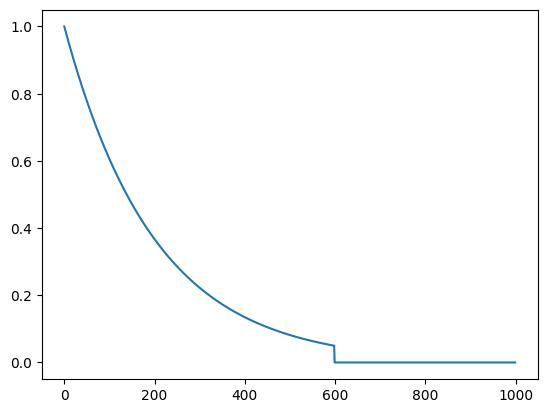

In [23]:
# Code from https://stackoverflow.com/questions/48583396/q-learning-epsilon-greedy-update
eps_start = 1.0
eps_min = 0.05
eps_decay = 0.995
epochs = 1000
pct = 0
df = np.zeros(epochs)
stop = 0
for i in range(epochs):
    if i == 0:
        df[i] = eps_start
    else:
        df[i] = df[i-1] * eps_decay
        if df[i] <= eps_min:
            print(i)
            stop = i
            break

print("With this parameter you will stop epsilon decay after {}% of training".format(stop/epochs*100))
plt.plot(df)
plt.show()

## Setting Parameters

In [256]:
start_iters = 0           # Starting iteration is 0 if not loading from checkpoing
num_iters = 1000          # Number of iterations to run for
num_eps = 50              # Number of episodes to execute during iteration
num_games = 40            # Number of games to play to see if new model will be accepted
update_threshold = 0.6    # Percent of games to win to update opponent model
epsilon = 1.0             # Probability of choosing random move for epsilon-greedy policy
epsilon_end = 0.05
epsilon_decay = 0.995
gamma = 0.99              # Discount factor for TD loss
tau = 1e-3                # Soft update parameter for target model
lr = 1e-3                 # Learning rate for optimizer
batch_size = 64           # Batch size of replay memory
criterion = nn.SmoothL1Loss()

input_channels = 19
dqn = DQN(input_channels).to(device)
target_dqn = DQN(input_channels).to(device)
target_dqn.load_state_dict(dqn.state_dict())

optimizer = optim.AdamW(dqn.parameters(), lr=lr)
rm = ReplayMemory(capacity=100000, batch_size=batch_size)

# Containers to store data
training_info = {
  'time_per_iter': np.full(num_iters, np.nan),
  'losses': np.full(num_iters, np.nan),
  'epsilons': np.full(num_iters, np.nan),
  'size_of_rm': np.full(num_iters, np.nan),
  'model_updates': np.full(num_iters, np.nan)
}

## Running Training

In [264]:
load_prev_checkpoint = True

if not load_prev_checkpoint:
  # Warmup replay memory before training
  warmup_size = rm.capacity * 0.1
  pbar = tqdm(total=warmup_size)
  while len(rm) < warmup_size:
    start_len = len(rm)
    white_train_examples, black_train_examples = execute_episode(dqn, epsilon=1)
    rm.extend(white_train_examples)
    rm.extend(black_train_examples)
    pbar.update(len(rm) - start_len)
  pbar.close()
else:
  (start_iters, epsilon, criterion, rm,
   dqn, target_dqn, optimizer, training_info) = load_checkpoint(os.path.join(checkpoint_path, 'checkpoint_latest.pth'))

In [ ]:
for iters in tqdm(range(start_iters, num_iters)):
  start_time = time.time()
  dqn.train()
  # Saving DQN model before training so we can use it to compare to new model
  opp_dqn = DQN(input_channels).to(device)
  opp_dqn.load_state_dict(dqn.state_dict())
  # Execute set number of episodes and add to replay buffer
  for eps in range(num_eps):
    white_train_examples, black_train_examples = execute_episode(dqn, epsilon)
    rm.extend(white_train_examples)
    rm.extend(black_train_examples)
  training_info['size_of_rm'][iters] = len(rm)

  # Call update to model
  loss = update(dqn, target_dqn, rm, optimizer, criterion=criterion, gamma=gamma, tau=tau)
  training_info['losses'][iters] = loss

  # Decrease epsilon
  epsilon = max(epsilon * epsilon_decay, epsilon_end)
  training_info['epsilons'][iters] = epsilon

  dqn_wins, opp_dqn_wins, draws = compete(dqn, opp_dqn, num_games=num_games, epsilon_end=epsilon_end)
  # Pit model against opp_model and keep updates from training if greater than a specified win rate
  if dqn_wins + opp_dqn_wins == 0 or float(dqn_wins) / (dqn_wins + opp_dqn_wins) < update_threshold:
    dqn.load_state_dict(opp_dqn.state_dict())
    if iters == 0:
      training_info['model_updates'][iters] = 0
    else:
      training_info['model_updates'][iters] = training_info['model_updates'][iters - 1]
  else:
    checkpoint_file_path = os.path.join(checkpoint_path, 'checkpoint_best.pth')
    save_checkpoint(iters, epsilon, criterion, rm, dqn, target_dqn, optimizer, training_info, checkpoint_file_path)
    if iters == 0:
      training_info['model_updates'][iters] = 0
    else:
      training_info['model_updates'][iters] = training_info['model_updates'][iters - 1] + 1

  # Tracking time to run an iteration
  end_time = time.time()
  training_info['time_per_iter'][iters] = end_time - start_time

  # Checkpoint model, optimizer, and replay buffer
  if (iters+1) % 5 == 0:
    checkpoint_file_path = os.path.join(checkpoint_path, 'checkpoint_latest.pth')
    save_checkpoint(iters, epsilon, criterion, rm, dqn, target_dqn, optimizer, training_info, checkpoint_file_path)
    plot_training_info(num_iters, training_info, checkpoint_path)

  0%|          | 3/975 [08:36<46:34:00, 172.47s/it]